In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import glob
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters
from statsmodels.tsa.ar_model import AutoReg

## 1. Leitura e tratamento de dados de entrada - Falhas:

In [2]:
path = r'3W\4' # use your path 3W\4
all_files = glob.glob(path + "/*.csv")

li = {}
le = {}
c = 0

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header = 0)
    li[c] = df.drop(columns = ['timestamp','QGL','T-JUS-CKGL','P-JUS-CKGL'])
    word = "WELL-"
    start_index=filename.index(word)
    wellNo= filename[start_index+5:start_index+10]
    df['id'] = wellNo
    df['id'] = pd.to_numeric(df['id'])
    df.head
    le[c] = df.drop(columns = ['QGL','T-JUS-CKGL','P-JUS-CKGL'])
    c += 1
    
    
frame = pd.concat(li, axis=0, ignore_index=True)
frame_wTime = pd.concat(le, axis=0, ignore_index=True)

In [3]:
frame_wTime['timestamp'] = pd.to_datetime(frame_wTime['timestamp'])

Extract statistical features from fault data using TSFRESH

In [4]:
def rolling_window(array, window=(0,), asteps=None, wsteps=None, axes=None, toend=True):
    """Create a view of `array` which for every point gives the n-dimensional
    neighbourhood of size window. New dimensions are added at the end of
    `array` or after the corresponding original dimension.
    
    Parameters
    ----------
    array : array_like
        Array to which the rolling window is applied.
    window : int or tuple
        Either a single integer to create a window of only the last axis or a
        tuple to create it for the last len(window) axes. 0 can be used as a
        to ignore a dimension in the window.
    asteps : tuple
        Aligned at the last axis, new steps for the original array, ie. for
        creation of non-overlapping windows. (Equivalent to slicing result)
    wsteps : int or tuple (same size as window)
        steps for the added window dimensions. These can be 0 to repeat values
        along the axis.
    axes: int or tuple
        If given, must have the same size as window. In this case window is
        interpreted as the size in the dimension given by axes. IE. a window
        of (2, 1) is equivalent to window=2 and axis=-2.       
    toend : bool
        If False, the new dimensions are right after the corresponding original
        dimension, instead of at the end of the array. Adding the new axes at the
        end makes it easier to get the neighborhood, however toend=False will give
        a more intuitive result if you view the whole array.
    
    Returns
    -------
    A view on `array` which is smaller to fit the windows and has windows added
    dimensions (0s not counting), ie. every point of `array` is an array of size
    window.
    
    Examples
    --------
    >>> a = np.arange(9).reshape(3,3)
    >>> rolling_window(a, (2,2))
    array([[[[0, 1],
             [3, 4]],

            [[1, 2],
             [4, 5]]],


           [[[3, 4],
             [6, 7]],

            [[4, 5],
             [7, 8]]]])
    
    Or to create non-overlapping windows, but only along the first dimension:
    >>> rolling_window(a, (2,0), asteps=(2,1))
    array([[[0, 3],
            [1, 4],
            [2, 5]]])
    
    Note that the 0 is discared, so that the output dimension is 3:
    >>> rolling_window(a, (2,0), asteps=(2,1)).shape
    (1, 3, 2)
    
    This is useful for example to calculate the maximum in all (overlapping)
    2x2 submatrixes:
    >>> rolling_window(a, (2,2)).max((2,3))
    array([[4, 5],
           [7, 8]])
           
    Or delay embedding (3D embedding with delay 2):
    >>> x = np.arange(10)
    >>> rolling_window(x, 3, wsteps=2)
    array([[0, 2, 4],
           [1, 3, 5],
           [2, 4, 6],
           [3, 5, 7],
           [4, 6, 8],
           [5, 7, 9]])
    """
    array = np.asarray(array)
    orig_shape = np.asarray(array.shape)
    window = np.atleast_1d(window).astype(int) # maybe crude to cast to int...
    
    if axes is not None:
        axes = np.atleast_1d(axes)
        w = np.zeros(array.ndim, dtype=int)
        for axis, size in zip(axes, window):
            w[axis] = size
        window = w
    
    # Check if window is legal:
    if window.ndim > 1:
        raise ValueError("`window` must be one-dimensional.")
    if np.any(window < 0):
        raise ValueError("All elements of `window` must be larger then 1.")
    if len(array.shape) < len(window):
        raise ValueError("`window` length must be less or equal `array` dimension.") 

    _asteps = np.ones_like(orig_shape)
    if asteps is not None:
        asteps = np.atleast_1d(asteps)
        if asteps.ndim != 1:
            raise ValueError("`asteps` must be either a scalar or one dimensional.")
        if len(asteps) > array.ndim:
            raise ValueError("`asteps` cannot be longer then the `array` dimension.")
        # does not enforce alignment, so that steps can be same as window too.
        _asteps[-len(asteps):] = asteps
        
        if np.any(asteps < 1):
             raise ValueError("All elements of `asteps` must be larger then 1.")
    asteps = _asteps
    
    _wsteps = np.ones_like(window)
    if wsteps is not None:
        wsteps = np.atleast_1d(wsteps)
        if wsteps.shape != window.shape:
            raise ValueError("`wsteps` must have the same shape as `window`.")
        if np.any(wsteps < 0):
             raise ValueError("All elements of `wsteps` must be larger then 0.")

        _wsteps[:] = wsteps
        _wsteps[window == 0] = 1 # make sure that steps are 1 for non-existing dims.
    wsteps = _wsteps

    # Check that the window would not be larger then the original:
    if np.any(orig_shape[-len(window):] < window * wsteps):
        raise ValueError("`window` * `wsteps` larger then `array` in at least one dimension.")

    new_shape = orig_shape # just renaming...
    
    # For calculating the new shape 0s must act like 1s:
    _window = window.copy()
    _window[_window==0] = 1
    
    new_shape[-len(window):] += wsteps - _window * wsteps
    new_shape = (new_shape + asteps - 1) // asteps
    # make sure the new_shape is at least 1 in any "old" dimension (ie. steps
    # is (too) large, but we do not care.
    new_shape[new_shape < 1] = 1
    shape = new_shape
    
    strides = np.asarray(array.strides)
    strides *= asteps
    new_strides = array.strides[-len(window):] * wsteps
    
    # The full new shape and strides:
    if toend:
        new_shape = np.concatenate((shape, window))
        new_strides = np.concatenate((strides, new_strides))
    else:
        _ = np.zeros_like(shape)
        _[-len(window):] = window
        _window = _.copy()
        _[-len(window):] = new_strides
        _new_strides = _
        
        new_shape = np.zeros(len(shape)*2, dtype=int)
        new_strides = np.zeros(len(shape)*2, dtype=int)
        
        new_shape[::2] = shape
        new_strides[::2] = strides
        new_shape[1::2] = _window
        new_strides[1::2] = _new_strides
    
    new_strides = new_strides[new_shape != 0]
    new_shape = new_shape[new_shape != 0]
    
    return np.lib.stride_tricks.as_strided(array, shape=new_shape, strides=new_strides)

In [5]:
a = np.arange(25).reshape(5,5)
b = rolling_window(a, (2,5), asteps=(2,5))

In [7]:
windowed_data = rolling_window(frame_wTime.to_numpy(), (900,frame_wTime.shape[1]), asteps=(900,frame_wTime.shape[1]))

In [15]:
df_fc_p = MinimalFCParameters() # See tsfresh's documentation
df_fc_p.pop('sum_values')       # Excludes inappropriate feature
df_fc_p.pop('length')           # Excludes inappropriate feature
df_fc_p.pop('maximum')           # Excludes inappropriate feature
df_fc_p.pop('absolute_maximum')           # Excludes inappropriate feature
df_fc_p.pop('minimum')           # Excludes inappropriate feature

tsfreshFeatures = []

for i in range(np.shape(windowed_data)[0]):
    windowed_frame = pd.DataFrame(windowed_data[i,0], columns=frame_wTime.columns)
    windowed_frame.dropna()
    extracted_features = extract_features(windowed_frame.drop(columns=['class']), column_id="id", column_sort="timestamp", default_fc_parameters=df_fc_p, impute_function=impute)
    extracted_features
    tsfreshFeatures.append(extracted_features.to_numpy())

Feature Extraction: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


ValueError: Column must not contain NaN values: P-PDG

In [9]:
df_fc_p

{'median': None, 'mean': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None}

In [12]:
extracted_features

,P-PDG__median,P-PDG__mean,P-PDG__standard_deviation,P-PDG__variance,P-PDG__root_mean_square,P-TPT__median,P-TPT__mean,P-TPT__standard_deviation,P-TPT__variance,P-TPT__root_mean_square,...,P-MON-CKP__median,P-MON-CKP__mean,P-MON-CKP__standard_deviation,P-MON-CKP__variance,P-MON-CKP__root_mean_square,T-JUS-CKP__median,T-JUS-CKP__mean,T-JUS-CKP__standard_deviation,T-JUS-CKP__variance,T-JUS-CKP__root_mean_square
1,38265830.0,38265830.0,0.0,0.0,38265830.0,14018450.0,14010580.2,59557.284019,3.547070e+09,1.401071e+07,...,5951106.5,5.943213e+06,49787.747432,2.478820e+09,5.943422e+06,68.53417,68.546162,0.161921,0.026218,68.546353


## 2. Leitura e tratamento de dados referentes a nominais:

In [17]:
path = r'3W\0' # use your path 3W\4
all_files = glob.glob(path + "/*.csv")

le = {}
li = {}
c = 0
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header = 0)
    li[c] = df.drop(columns = ['timestamp','QGL','T-JUS-CKGL'])

    word = "WELL-"
    start_index=filename.index(word)
    wellNo= filename[start_index+5:start_index+10]
    df['id'] = wellNo
    df['id'] = pd.to_numeric(df['id'])
    df.head
    le[c] = df.drop(columns = ['QGL','T-JUS-CKGL','P-JUS-CKGL'])

    c += 1

frame = pd.concat(li, axis=0, ignore_index=True)
frame_wTime = pd.concat(le, axis=0, ignore_index=True)


In [18]:
frame_wTime['timestamp'] = pd.to_datetime(frame_wTime['timestamp'])


In [20]:
frame_wTime

,timestamp,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class,id
0,2017-02-01 02:02:07,0.0,10092110.0,119.0944,1609800.0,84.59782,0,1
1,2017-02-01 02:02:08,0.0,10092000.0,119.0944,1618206.0,84.58997,0,1
2,2017-02-01 02:02:09,0.0,10091890.0,119.0944,1626612.0,84.58213,0,1
3,2017-02-01 02:02:10,0.0,10091780.0,119.0944,1635018.0,84.57429,0,1
4,2017-02-01 02:02:11,0.0,10091670.0,119.0944,1643424.0,84.56644,0,1
...,...,...,...,...,...,...,...,...
9956786,2017-09-14 16:56:34,25737530.0,13132670.0,109.5569,NaN,NaN,0,8
9956787,2017-09-14 16:56:35,25737540.0,13132630.0,109.5562,NaN,NaN,0,8
9956788,2017-09-14 16:56:36,25737540.0,13132580.0,109.5556,NaN,NaN,0,8
9956789,2017-09-14 16:56:37,25737550.0,13132540.0,109.5549,NaN,NaN,0,8


Extract statistical features from nominal data using TSFRESH

In [44]:
windowed_data = rolling_window(frame_wTime.to_numpy(), (900,frame_wTime.shape[1]), asteps=(900,frame_wTime.shape[1]))

In [27]:
df_fc_p = MinimalFCParameters() # See tsfresh's documentation
df_fc_p.pop('sum_values')       # Excludes inappropriate feature
df_fc_p.pop('length')           # Excludes inappropriate feature

tsfreshFeatures_nom = []

for i in range(np.shape(windowed_data)[0]):
    windowed_frame_nom = pd.DataFrame(windowed_data[i,0],columns=frame_wTime.columns)
    windowed_frame_nom.dropna()
    extracted_features_nom = extract_features(windowed_frame_nom.drop(columns=['class']), column_id="id", column_sort="timestamp",default_fc_parameters=df_fc_p,impute_function=impute)
    extracted_features_nom
    tsfreshFeatures_nom.append(extracted_features_nom.to_numpy())

Feature Extraction: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


ValueError: Column must not contain NaN values: P-PDG

## 3. Modelo de aprendizado de máquina:

In [54]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [55]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### a) SVM

c:\Users\rodri\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


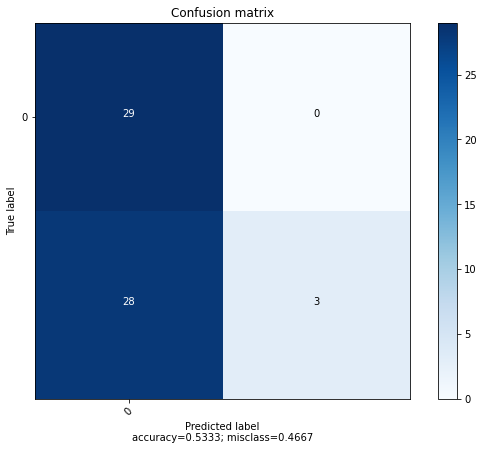

In [56]:
from sklearn.svm import LinearSVC

standart_scaler = preprocessing.StandardScaler()
Feat_scaler = standart_scaler.fit_transform(Dados[:,:3])
Y = Dados[:,-1]

x_train, x_test, y_train, y_test = train_test_split(Feat_scaler, Y, test_size = 0.2, random_state = 0 )
modelo_svc = LinearSVC(C = 1, loss = 'hinge', random_state = 42)
modelo_svc.fit(x_train, y_train)

y_pred = modelo_svc.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, target_names = range(0,1))

In [57]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.model_selection import RepeatedKFold

c:\Users\rodri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan -0.4556578  -0.47457447         nan -0.45742553 -0.45538652
 -0.4555922  -0.46084574 -0.46274468         nan -0.45252482         nan
         nan -0.45578901         nan         nan -0.45683333         nan
         nan         nan         nan         nan -0.45946631         nan
         nan -0.46188298         nan         nan         nan         nan
         nan -0.45656915         nan -0.46450532 -0.46909929         nan
 -0.46127837         nan         nan -0.45301596         nan         nan
 -0.46032092 -0.4563883  -0.45509397 -0.46116135 -0.45728191         nan
 -0.46446454         nan         nan -0.45933156         nan         nan
         nan         nan -0.46067376         nan         nan -0.45469326
         nan -0.45188121 -0.47090957         nan         nan -0.45525709
         nan -0.4512039          nan -0.46861525      

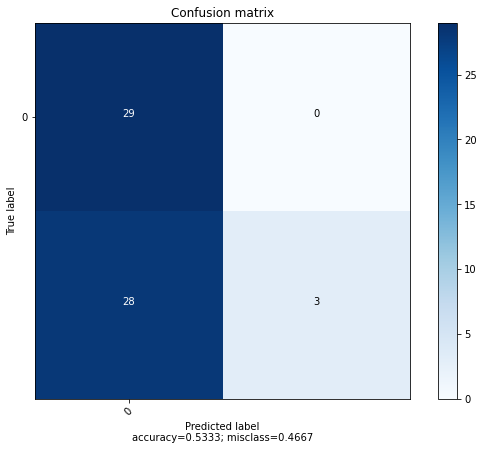

In [58]:
rkf = RepeatedKFold(n_splits = 5, n_repeats = 50, random_state = 42)
rkf.split(x_train, y_train)

# Randomized Search
rand_parameters = [{'C':range(1,100), 'loss':['hinge', 'square_hinge']}]
modelo_svc = LinearSVC() 
random_search_svm = RandomizedSearchCV(modelo_svc, rand_parameters, verbose = 0, n_iter = 100,
                                       n_jobs = -1, cv = rkf, scoring = 'neg_mean_squared_error', random_state=42)
random_search_svm.fit(x_train, y_train)
BPSVC = random_search_svm.best_params_

yh = random_search_svm.predict(x_test)

cm = confusion_matrix(y_test, yh)

plot_confusion_matrix(cm, target_names = range(0,1))

c:\Users\rodri\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


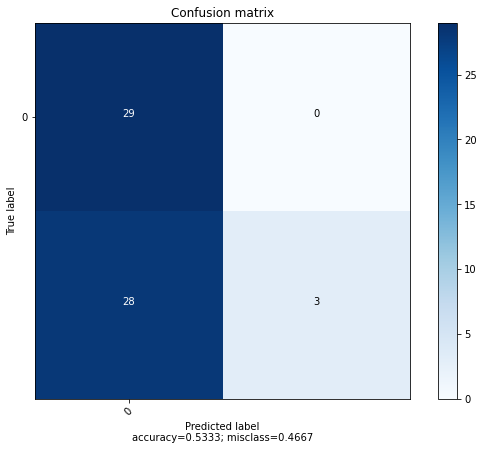

In [59]:
x_train, x_test, y_train, y_test = train_test_split(Feat_scaler, Y, test_size = 0.2, random_state = 0 )
modelo_svc = LinearSVC(C = 67, loss = 'hinge', random_state = 42)
modelo_svc.fit(x_train, y_train)

y_pred = modelo_svc.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, target_names = range(0,1))

#### Truque do Kernel

##### a. Kernel polinomial:

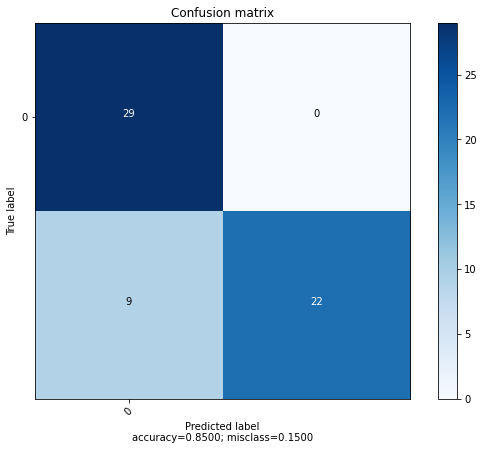

In [60]:
modelo_svc = SVC(C = 63, kernel = 'poly', degree = 2, random_state = 42)
modelo_svc.fit(x_train, y_train)

y_pred = modelo_svc.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, target_names = range(0,1))

##### a. Kernel Gaussiano:

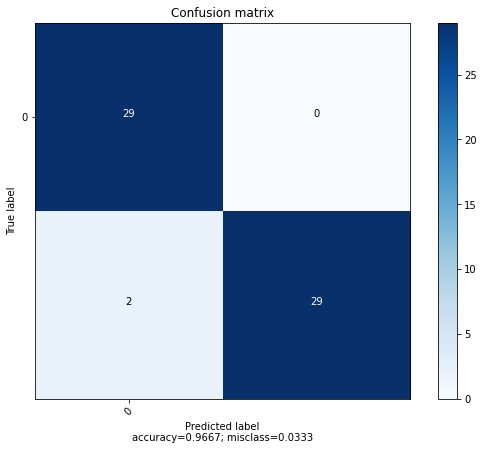

In [61]:
modelo_svc = SVC(C = 63, kernel = 'rbf', gamma = 5, random_state = 42)
modelo_svc.fit(x_train, y_train)

y_pred = modelo_svc.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, target_names = range(0,1))

### b) Random Forest

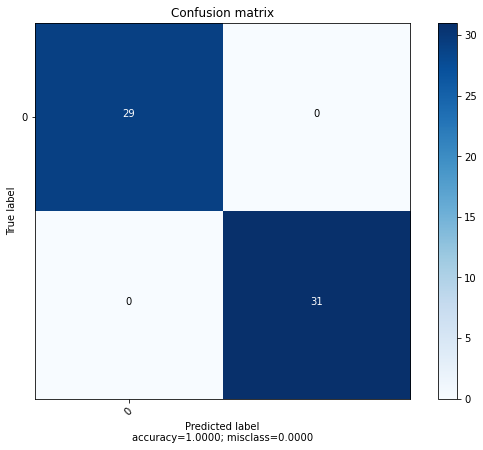

In [62]:
from scipy.stats import randint,uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 500, n_jobs= -1)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

plot_confusion_matrix(confusion_matrix(y_test,y_pred), target_names= range(0,1))

In [151]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
            }


# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [156]:
from sklearn.model_selection import cross_val_score 


acc = cross_val_score(estimator=rf_random,X=x_train,y=y_train,cv=3)



Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [157]:
acc

array([1.        , 0.9625    , 0.98734177])

In [152]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_depth': 100}

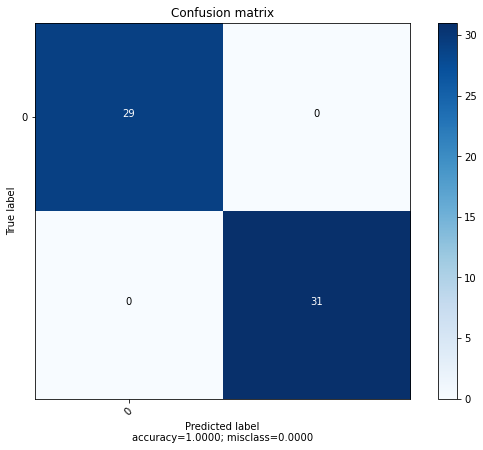

In [153]:
y_pred = rf_random.predict(x_test)

plot_confusion_matrix(confusion_matrix(y_test,y_pred), target_names= range(0,1))

# DISCUTIR E-MAIL DO HELON